# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 :    김지원
- 기수 :     11기



## 해당 과제에는 6개의 섹션과 7개의 문제가 있습니다! 누락없이 제출 부탁드립니다 :)

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [2]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/03)DSL/0_정기세미나/기초과제/기초과제4/[240206]_CNN_JiwonKim/scripts

/content/drive/MyDrive/03)DSL/0_정기세미나/기초과제/기초과제4/[240206]_CNN_JiwonKim/scripts


In [4]:
# 이번 과제의 일부였던 CustomDataset.py, Model.py를 로드해주세요
from CustomDataset import CustomImageDataset
from Model import ResNet50

import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [5]:
# config.yaml의 위치를 지정해주세요
config_path = "./config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [6]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"]) # config.yaml에서 이미 float 자료형으로 학습률을 정의하신 분은 float()으로 자료형 변환을 하지 않으셔도 됩니다.



In [7]:
print(epoch)
print(batch_size)
print(lr)

40
80
0.001


In [8]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet", entity="jwkim808",
    name='agument_exist',
    config={
        "model_name": 'ResNet',
        "epochs": epoch,
        "batch_size":batch_size,
        "lr": lr
    })

config = wandb.config

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

### 문제 1.

모델의 학습을 train, validation, test로 나눠서 진행하는 이유는 무엇인가요?
- (힌트 : 굳이 validation을 끼워넣는 이유는 무엇인가요?)
- Answer: train data에 과적합 방지

### 문제 2.

모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다.

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 특정 단계에서만 Augmention를 수행하게 됩니다. 어느 단계에서 RandAugment가 적용되어야하는지와, 그 이유에 대해서 설명해주세요.
- Answer: Train 단계에서 적용합니다. augmentation을 사용하면 다양한 input을 통해 model을 학습시킬 수 있으며 충분한 양의 train data를 확보하고 모델의 성능을 향상시키 줍니다.

### 문제 3.
CustomImageDataset과 DataLoader 클래스의 차이점에 대해서 설명해주세요.
- (힌트 : 두 클래스의 리턴 형식에 어떤 차이가 있나요? 어디서부터 Batch 단위로 리턴되나요?)
- Answer:
- CustomImageDataset과 DataLoader 클래스는 PyTorch에서 데이터를 로딩하고 처리하는 데 사용되지만, 그 역할과 기능이 다릅니다.
- **CustomImageDataset**: 이 클래스는 데이터셋을 정의할 때 사용됩니다. 사용자는 이 클래스를 통해 데이터셋의 로딩 방식, 전처리 방식 등을 커스텀할 수 있습니다. CustomImageDataset은 데이터의 개별 항목을 로드하고 전처리하는 방식을 정의합니다. 보통 '__getitem__' 메소드를 통해 데이터셋의 특정 인덱스에 있는 데이터와 레이블을 리턴합니다.

- **DataLoader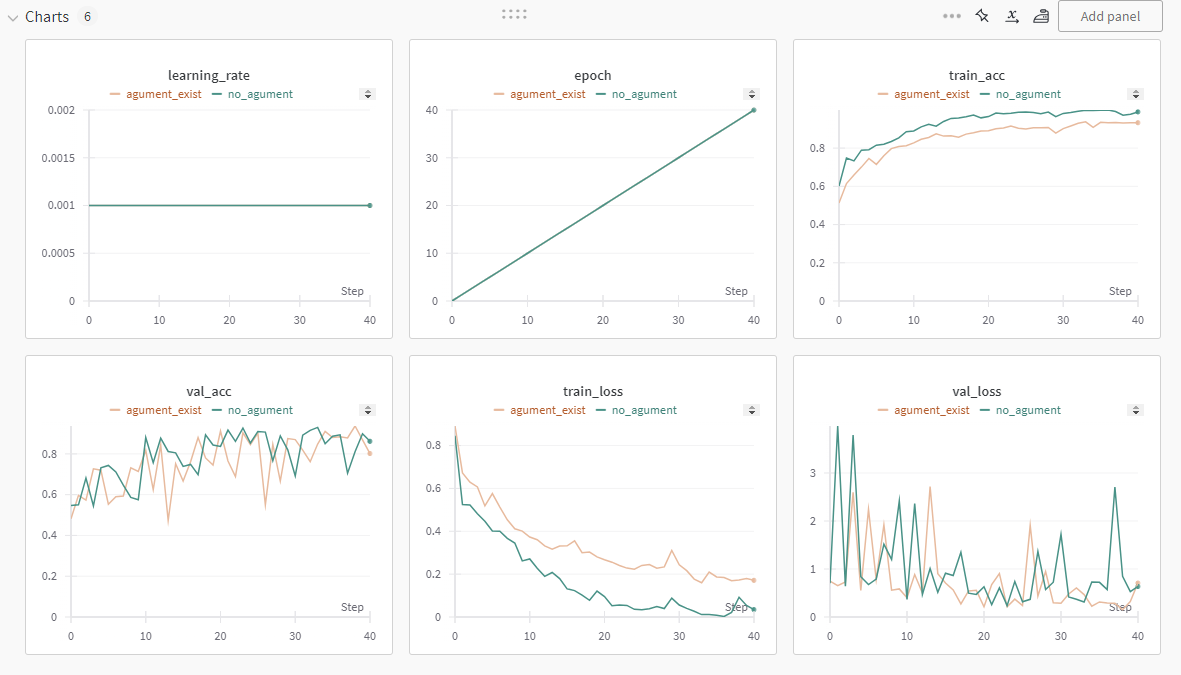**: 이 클래스는 CustomImageDataset 같은 데이터셋 객체를 입력으로 받아, 배치 단위로 데이터를 불러오고, 필요한 경우 데이터를 섞거나 다중 프로세스를 사용하여 데이터 로딩을 가속화하는 역할을 합니다. DataLoader는 데이터셋에서 데이터를 효율적으로 배치로 만들어 모델에 공급하는 데 사용됩니다. 이를 통해 학습 과정의 효율성을 높일 수 있습니다.

- 결론적으, CustomImageDataset은 데이터셋의 로딩과 전처리를 담당하며, DataLoader는 이러한 데이터셋을 배치 단위로 모델에 공급하기 위해 사용됩니다. 따라서, DataLoader를 사용하는 단계에서부터 데이터는 배치 단위로 리턴됩니다.

In [10]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv('./MetaData.csv')

# train : val : test = 6 : 2 : 2
train, val_test = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_test, train_size=0.5, random_state=777)

# Model generalization을 위해 RandomAugmentation에 어떤 변형을 가할 지 transforms.Compose([])로 묶어놓읍시다
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=train, transform = train_transforms)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=val, transform = train_transforms)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=test, transform = train_transforms)


train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

### 문제 4.

주어진 과제는 Binary Classification 태스크입니다.

이중 분류를 위해서는 손실함수로 Binary Cross Entropy를 사용한다고 세션에서 배웠습니다.

PyTorch에는 Binary Cross Entropy를 학습에 사용할 수 있는 2가지 방법이 있는데요, 'nn.BCELoss'와 'nn.BCEWithLogitsLoss'입니다.

이 둘은 같아 보이지만 구현상에서 명백한 차이점이 있습니다.

이 둘의 차이점에 대해서 서술해주세요.
- Answer:
- **활성화 함수의 적용**: nn.BCELoss는 모델의 출력에 sigmoid 활성화 함수가 적용된 후의 확률 값을 입력으로 사용해야 합니다. 반면, nn.BCEWithLogitsLoss는 sigmoid 함수의 적용 없이, 모델의 원시 로짓 값을 직접 입력으로 사용합니다.
- **수치적 안정성**: nn.BCEWithLogitsLoss는 로짓에 대해 sigmoid를 적용하는 과정과 BCE 손실 계산을 결합함으로써 수치적으로 더 안정적입니다. 이는 로그-시그모이드 계산의 수치적 불안정성을 줄여줍니다.
- **효율성**: nn.BCEWithLogitsLoss는 하나의 단계에서 활성화 함수 적용과 손실 계산을 모두 처리하기 때문에 계산적으로 더 효율적이고, 이를 통해 더 나은 성능과 안정성을 제공합니다.


In [11]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50()
model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [12]:
from torchsummary import summary
summary(model,(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
from torchvision.models import resnet50

resnet_pretrained = resnet50().cuda()
summary(resnet_pretrained, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
# 손실함수를 정의해주세요
criterion = nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요
optimizer = torch.optim.Adam(model.parameters(), lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

### 문제 5.
학습이 끝난 이후 val_loss, train_loss 변화 추이 그래프와 val_acc, train_acc 변화 추이 그래프를 첨부해주세요.
(wandb 대시보드에서 캡쳐하셔도 됩니다)

In [15]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")

# Training, Validation 시작
for curr_epoch in range(epoch + 1):  # iterate over all EPOCHS
    train_loss = 0
    correct_train = 0
    total_train = 0  # 총 학습 데이터 수를 계산하기 위한 변수

    print("")
    model.train()  # 모델을 학습 모드로 설정
    for img, label in train_loader:  # iterate over all BATCHES
        img, label = img.to(device), label.to(device)  # GPU에 데이터 올리기
        pred = model(img)  # Forward Propagation

        label = label.view(-1, 1).float()  # 목표 텐서의 모양 조정
        loss = criterion(pred, label)  # 손실함수 계산

        optimizer.zero_grad()  # 누적된 기울기 초기화
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        train_loss += loss.item()  # 해당 Batch에서의 loss 누적

        pred_class = (torch.sigmoid(pred) > 0.5).float()  # 이진 분류를 위한 임계값 적용
        correct_train += (pred_class == label).float().sum()  # 정확도 계산
        total_train += label.size(0)

    train_loss /= len(train_loader)  # 평균 학습 손실
    train_acc = correct_train / total_train  # 평균 학습 정확도

    # Validation 시작
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0
    correct_val = 0
    total_val = 0  # 총 검증 데이터 수를 계산하기 위한 변수
    with torch.no_grad():  # 기울기 계산을 하지 않음
        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            pred = model(img)
            label = label.view(-1, 1).float()

            loss = criterion(pred, label)  # 손실함수 계산
            val_loss += loss.item()  # 해당 Batch에서의 loss 누적

            pred_class = (torch.sigmoid(pred) > 0.5).float()  # 이진 분류를 위한 임계값 적용
            correct_val += (pred_class == label).float().sum()  # 정확도 계산
            total_val += label.size(0)

    val_loss /= len(val_loader)  # 평균 검증 손실
    val_acc = correct_val / total_val  # 평균 검증 정확도

    print(f"Epoch {curr_epoch}/{epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    metrics = {
        "epoch": curr_epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc.item(),
        "val_acc": val_acc.item(),
        "learning_rate": lr
    }

    wandb.log(metrics)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt"))

wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0/40, Train Loss: 0.8913, Train Acc: 0.5128, Val Loss: 0.7486, Val Acc: 0.4817

Epoch 1/40, Train Loss: 0.6725, Train Acc: 0.6144, Val Loss: 0.6523, Val Acc: 0.5967

Epoch 2/40, Train Loss: 0.6294, Train Acc: 0.6589, Val Loss: 0.7280, Val Acc: 0.5733

Epoch 3/40, Train Loss: 0.6067, Train Acc: 0.7006, Val Loss: 2.5956, Val Acc: 0.7267

Epoch 4/40, Train Loss: 0.5184, Train Acc: 0.7461, Val Loss: 0.5532, Val Acc: 0.7200

Epoch 5/40, Train Loss: 0.5761, Train Acc: 0.7150, Val Loss: 2.2397, Val Acc: 0.5533

Epoch 6/40, Train Loss: 0.5128, Train Acc: 0.7606, Val Loss: 0.7801, Val Acc: 0.5900

Epoch 7/40, Train Loss: 0.4537, Train Acc: 0.7972, Val Loss: 1.9195, Val Acc: 0.5933

Epoch 8/40, Train Loss: 0.4118, Train Acc: 0.8083, Val Loss: 0.5576, Val Acc: 0.7317

Epoch 9/40, Train Loss: 0.4007, Train Acc: 0.8128, Val Loss: 0.5849, Val Acc: 0.7133

Epoch 10/40, Train Loss: 0.3734, Train Acc: 0.8272, Val Loss: 0.4027, Val Acc: 0.8167

Epoch 11/40, Train Loss: 0.3605, Train Acc: 0.8461, V

# 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록합시다.

이후에는 confusion matrix, accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.

### 문제6.

accuracy 95% 이상이 되도록 학습률 등을 조절해주세요.

In [16]:
trained_model = ResNet50() # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


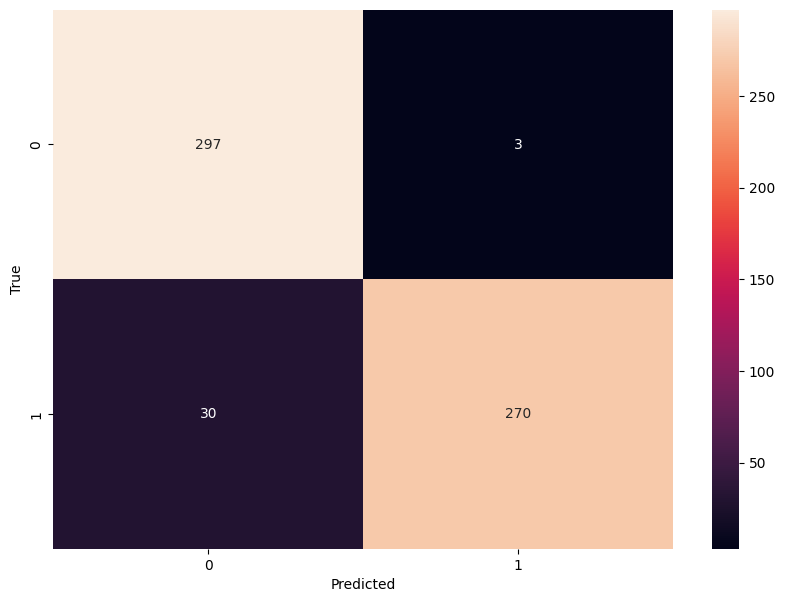

Accuracy: 94.50%


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for image, label in test_loader:
  image, label = image.to(device), label.to(device)

  with torch.no_grad(): # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    pred = trained_model(image) # 순전파

    probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률을 계산합니다
    predicted = (probabilities > 0.5).float()  # 확률을 label로 바꿔줍니다

    all_labels.extend(label.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# 6. Augmentation vs No Augmentation

### 문제 7.

전달받으신 파일들 중, Run_NoAugment.ipynb라는 파일이 있을 겁니다.

지금 보고 계신 노트북과 똑같이 학습을 시키시되, 이번에는 학습 시 data augmentation을 적용시키지 않고 진행하십시오.

이후 augmentation을 적용시키지 않은 모델의 train loss와 val loss의 차트를 아래에 붙여놓으시고,

augmentation을 적용한 모델의 학습 양상과 어떤 점이 다른 지와 그 이유도 함께 설명해주세요.
- Answer: train data의 크기로 인해 train accuracy가 다르게 나오는 것 같습니다. 해당 데이터는 오히려 데이터가 많아질수록 train accuracy가 낮아진 것을 볼 수 있습니다.

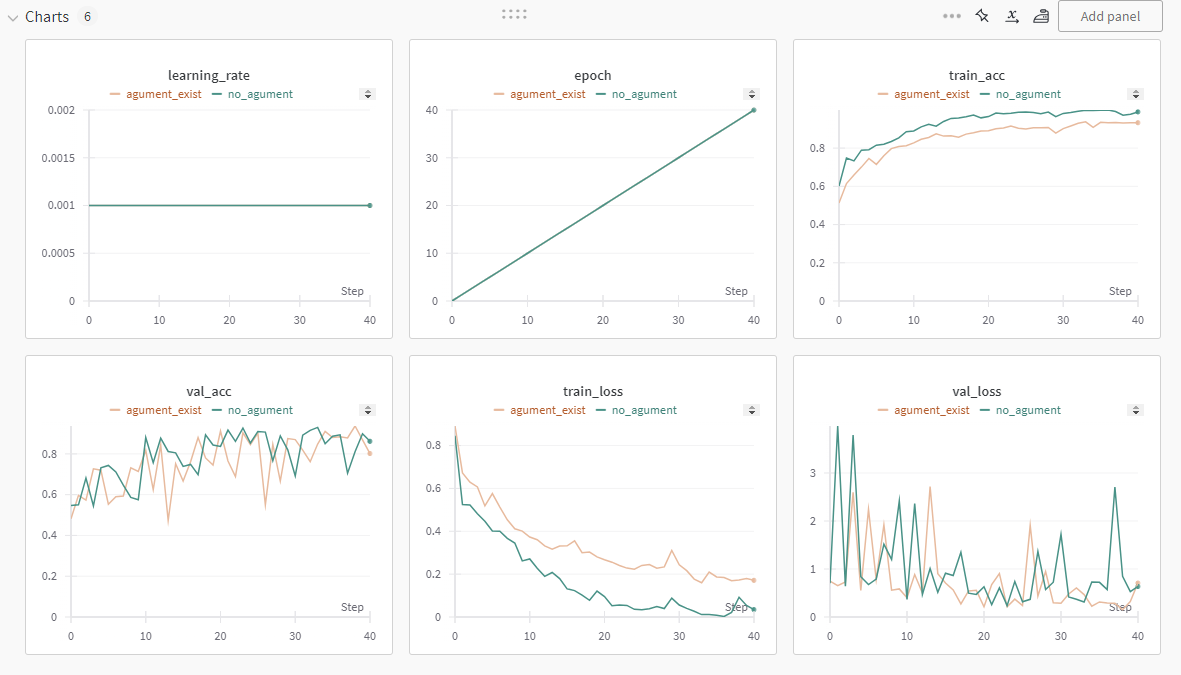